# Scaling up Hyperparameter Optimization with NVIDIA DGX Cloud and XGBoost GPU Algorithm

Choosing an optimal set of hyperparameters is a daunting task, especially for algorithms like XGBoost that have many hyperparameters to tune. In this notebook, we will show how to speed up hyperparameter optimization by running multiple training jobs in parallel on [NVIDIA DGX Cloud](https://www.nvidia.com/en-us/data-center/dgx-cloud/).

# Prerequisites

````{docref} /cloud/nvidia/bcp
Please follow instructions in [NVIDIA DGX Cloud (Base Command Platform)](../../cloud/nvidia/bcp) to launch a Base Command Platform (BCP) job with RAPIDS.

```{note}
When configuring your cluster ensure you install `optuna` as we will use it later in the notebook.

![](../../_static/images/examples/xgboost-gpu-hpo-job-parallel-ngc/optuna-package.png)
```

Once your cluster is running and you have access to Jupyter save this notebook and run through the cells.

````

## Connect to Dask cluster

In [2]:
from dask.distributed import Client

client = Client("ws://localhost:8786")
client

<Client: 'ws://100.96.148.133:8786' processes=14 threads=14, memory=800.00 GiB>

In [5]:
n_workers = len(client.scheduler_info()["workers"])

# Perform hyperparameter optimization with a toy example

Now we can run hyperparameter optimization. The workers will run multiple training jobs in parallel.

In [3]:
def objective(trial):
    x = trial.suggest_uniform("x", -10, 10)
    return (x - 2) ** 2

In [6]:
import optuna
from dask.distributed import wait

# Number of hyperparameter combinations to try in parallel
n_trials = 100

# Optimize in parallel on your Dask cluster
backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)
study = optuna.create_study(direction="minimize", storage=dask_storage)

futures = []
for i in range(0, n_trials, n_workers * 4):
    iter_range = (i, min([i + n_workers * 4, n_trials]))
    futures.append(
        {
            "range": iter_range,
            "futures": [
                client.submit(study.optimize, objective, n_trials=1, pure=False)
                for _ in range(*iter_range)
            ],
        }
    )
for partition in futures:
    iter_range = partition["range"]
    print(f"Testing hyperparameter combinations {iter_range[0]}..{iter_range[1]}")
    _ = wait(partition["futures"])

/tmp/ipykernel_618/3307148639.py:9: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)


Testing hyperparameter combinations 0..56
Testing hyperparameter combinations 56..100


In [7]:
study.best_params

{'x': 1.9717191009722854}

In [8]:
study.best_value

0.0007998092498157874

# Perform hyperparameter optimization with XGBoost GPU algorithm

Now let's try optimizing hyperparameters for an XGBoost model.

In [9]:
import xgboost as xgb
from optuna.samplers import RandomSampler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold, cross_val_score


def objective(trial):
    X, y = load_breast_cancer(return_X_y=True)
    params = {
        "n_estimators": 10,
        "verbosity": 0,
        "tree_method": "gpu_hist",
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": trial.suggest_float(
            "min_child_weight", 1e-8, 100, log=True
        ),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": "depthwise",
        "eval_metric": "logloss",
    }
    clf = xgb.XGBClassifier(**params)
    fold = KFold(n_splits=5, shuffle=True, random_state=0)
    score = cross_val_score(clf, X, y, cv=fold, scoring="neg_log_loss")
    return score.mean()

In [16]:
# Number of hyperparameter combinations to try in parallel
n_trials = 1000

# Optimize in parallel on your Dask cluster
backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)
study = optuna.create_study(
    direction="maximize", sampler=RandomSampler(seed=0), storage=dask_storage
)
futures = []
for i in range(0, n_trials, n_workers * 4):
    iter_range = (i, min([i + n_workers * 4, n_trials]))
    futures.append(
        {
            "range": iter_range,
            "futures": [
                client.submit(study.optimize, objective, n_trials=1, pure=False)
                for _ in range(*iter_range)
            ],
        }
    )
for partition in futures:
    iter_range = partition["range"]
    print(f"Testing hyperparameter combinations {iter_range[0]}..{iter_range[1]}")
    _ = wait(partition["futures"])

/tmp/ipykernel_618/4264989174.py:6: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)


Testing hyperparameter combinations 0..56
Testing hyperparameter combinations 56..112
Testing hyperparameter combinations 112..168
Testing hyperparameter combinations 168..224
Testing hyperparameter combinations 224..280
Testing hyperparameter combinations 280..336
Testing hyperparameter combinations 336..392
Testing hyperparameter combinations 392..448
Testing hyperparameter combinations 448..504
Testing hyperparameter combinations 504..560
Testing hyperparameter combinations 560..616
Testing hyperparameter combinations 616..672
Testing hyperparameter combinations 672..728
Testing hyperparameter combinations 728..784
Testing hyperparameter combinations 784..840
Testing hyperparameter combinations 840..896
Testing hyperparameter combinations 896..952
Testing hyperparameter combinations 952..1000


In [17]:
study.best_params

{'lambda': 1.9471539598103378,
 'alpha': 1.1141784696858766e-08,
 'colsample_bytree': 0.7422532294369841,
 'max_depth': 4,
 'min_child_weight': 0.2248745054413427,
 'learning_rate': 0.4983200494234886,
 'gamma': 9.77293810275356e-07}

In [18]:
study.best_value

-0.10351123544715746

Let's visualize the progress made by hyperparameter optimization.

In [19]:
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
)

/tmp/ipykernel_618/3324289224.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

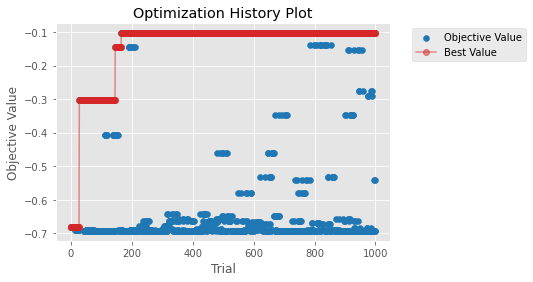

In [20]:
plot_optimization_history(study)

/tmp/ipykernel_618/3836449081.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

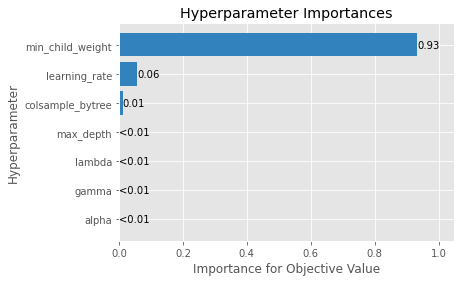

In [21]:
plot_param_importances(study)